# Explore here

In [222]:

import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
import joblib
import os
os.makedirs("modelos", exist_ok=True)

In [223]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv"
df = pd.read_csv(url)
df.to_csv("../data/raw/data.csv", index=False)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [225]:
df_new = df[["Latitude", "Longitude", "MedInc"]]
df_new

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462
...,...,...,...
20635,39.48,-121.09,1.5603
20636,39.49,-121.21,2.5568
20637,39.43,-121.22,1.7000
20638,39.43,-121.32,1.8672


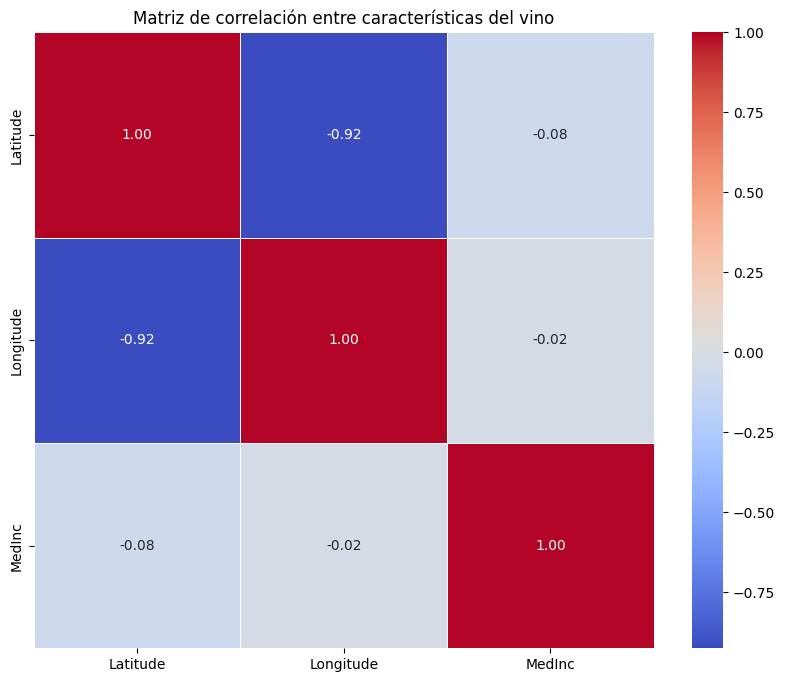

In [226]:
# Mapa de calor de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(df_new.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación entre características del vino")
plt.show()


*Latitud* y *Longitud*, tienen una correlación negativa fuerte de -0.92. Esto significa que, a medida que la latitud aumenta, la longitud tiende a disminuir. Y por otro lado, 
*Latitud* y *MedInc*, presentan una correlación negativa débil de -0.08. Esto nos dice que la latitud tiene poco impacto en la media de ingresos.
*Longitud y MedInc*, la relación es casi nula, lo que indica que la variación en la longitud no afecta significativamente los ingresos medios.

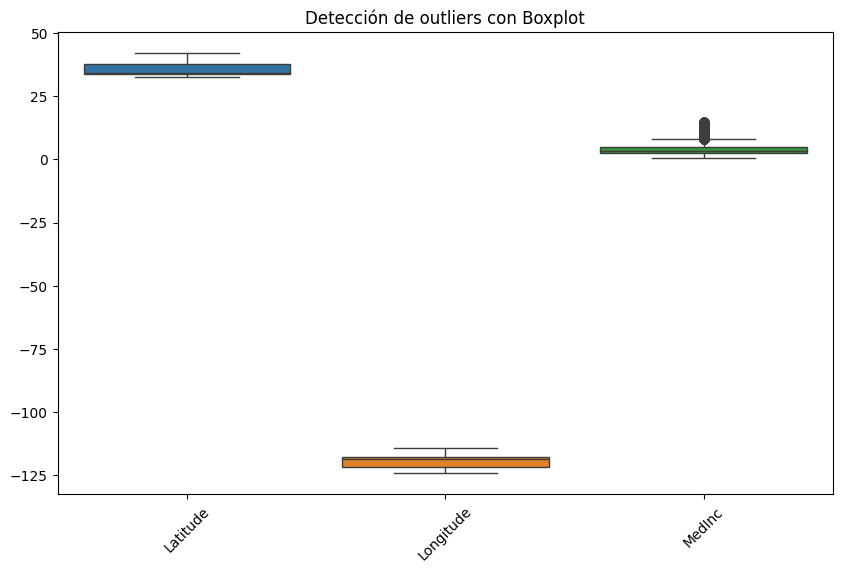

In [227]:
# Crear boxplots para todas las variables numéricas y 
# detallar los posibles outliers

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_new)
plt.xticks(rotation=45)
plt.title("Detección de outliers con Boxplot")
plt.show()

En el grafico podemos observar que no existen outliers en *latitude* ni *longitude*, pero si en *MedInc* asi que eliminaremos esos outliers para que no afecten nuestro analisis. 

In [228]:
#Outliers
Q1 = df_new['MedInc'].quantile(0.25)
Q3 = df_new['MedInc'].quantile(0.75)
IQR = Q3 - Q1

df_new_2 = df_new[(df_new['MedInc'] >= Q1 - 1.5 * IQR) & (df_new['MedInc'] <= Q3 + 1.5 * IQR)]
print("Datos después de eliminar outliers:", df_new_2.shape)

Datos después de eliminar outliers: (19959, 3)


In [229]:
df_new_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19959 entries, 2 to 20639
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   19959 non-null  float64
 1   Longitude  19959 non-null  float64
 2   MedInc     19959 non-null  float64
dtypes: float64(3)
memory usage: 623.7 KB


El dataset tiene 19,959 entradas con 3 columnas numericas.
Latitude y Longitude: Ubicaciones geográficas, y podrían ser útiles para segmentación por zonas o regiones. Y MedInc, indica un valor económico.

Sin valores nulos.

In [230]:
#dividimos en train y test
X_train, X_test = train_test_split(df_new_2, test_size=0.2, random_state=42)
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)


Tamaño de X_train: (15967, 3)
Tamaño de X_test: (3992, 3)


In [231]:
#Escalar los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

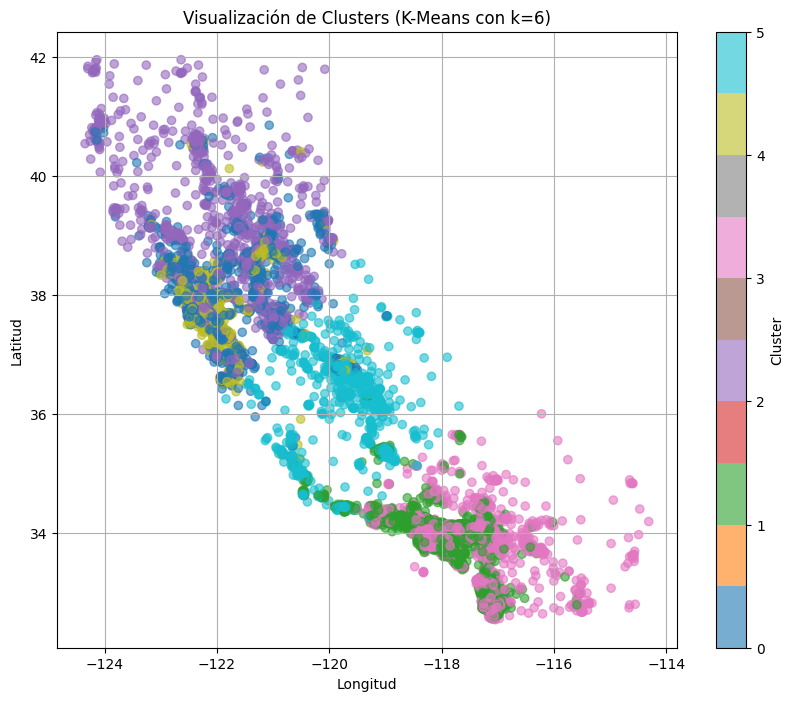

In [232]:
# Entrenar el modelo con el conjunto de entrenamiento
# Entrenar K-Means con k=6
scaler = StandardScaler()
df_new_2 = df_new_2.copy()
df_new_2.loc[:, 'MedInc'] = scaler.fit_transform(df_new_2[['MedInc']]).flatten()
kmeans = KMeans(n_clusters=6, random_state=42)
X_train_clusters = kmeans.fit_predict(X_train_scaled)

# Añadir los clusters al conjunto de entrenamiento original
X_train['Cluster'] = X_train_clusters

# Visualización de clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train['Longitude'], X_train['Latitude'], c=X_train['Cluster'], cmap='tab10', alpha=0.6)
plt.title("Visualización de Clusters (K-Means con k=6)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


El grafico nos indica que el modelo ha logrado identificar patrones claros en alguno de los datos, es decir que el algoritmo logró segmentar el espacio en regiones bien diferenciadas., los colores represnetar un cluster que permite. Visualmente, no parece que un solo cluster domine de forma clara. Pero convendría verificar para ver si hay desbalance significativo.

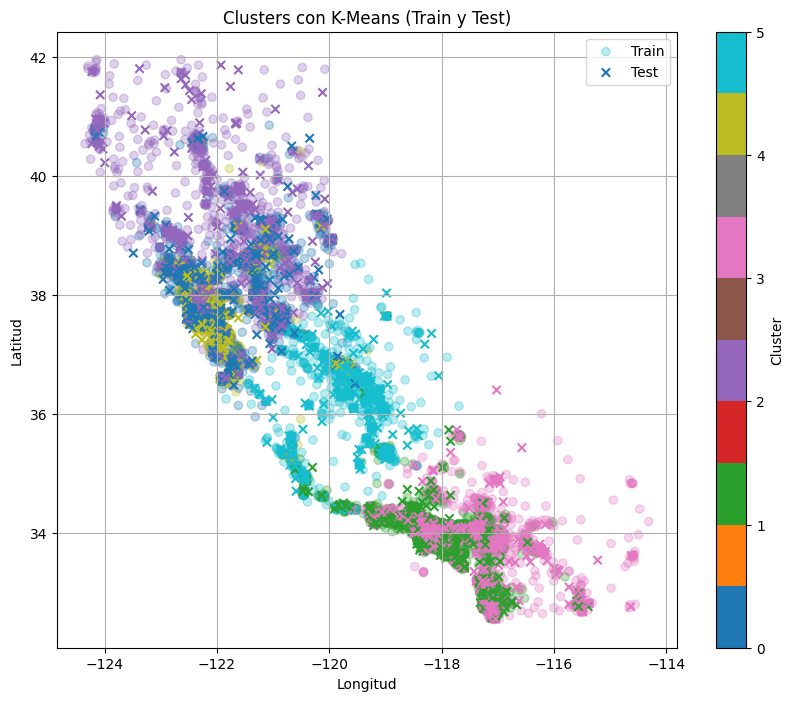

In [233]:
# Predecir los clusters en el conjunto de test
X_test_clusters = kmeans.predict(X_test_scaled)
X_test['Cluster'] = X_test_clusters

# Visualizar ambos conjuntos: train y test
plt.figure(figsize=(10, 8))

# Puntos del conjunto de entrenamiento
plt.scatter(X_train['Longitude'], X_train['Latitude'], c=X_train['Cluster'], cmap='tab10', alpha=0.3, label='Train')

# Puntos del conjunto de test
plt.scatter(X_test['Longitude'], X_test['Latitude'], c=X_test['Cluster'], cmap='tab10', marker='x', label='Test')

plt.title("Clusters con K-Means (Train y Test)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.colorbar(label='Cluster')
plt.legend()
plt.grid(True)
plt.show()


In [234]:
from sklearn.neighbors import KNeighborsClassifier

# Definir variables
y_train = X_train['Cluster']
y_test = X_test['Cluster']

# Entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predecir
y_pred = knn.predict(X_test_scaled)

# Evaluación
print("Precisión (accuracy):", accuracy_score(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Precisión (accuracy): 0.9917334669338678

Matriz de confusión:
[[ 645    0    5    0    2    1]
 [   0  878    0    3    1    0]
 [   5    0  538    0    0    1]
 [   0    6    0 1253    0    1]
 [   4    1    0    0  329    0]
 [   0    2    1    0    0  316]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       653
           1       0.99      1.00      0.99       882
           2       0.99      0.99      0.99       544
           3       1.00      0.99      1.00      1260
           4       0.99      0.99      0.99       334
           5       0.99      0.99      0.99       319

    accuracy                           0.99      3992
   macro avg       0.99      0.99      0.99      3992
weighted avg       0.99      0.99      0.99      3992



Analisis de modelo RandomForest:
*Precision*, el modelo clasifica correctamente el 99.17% de los ejemplos en el conjunto de prueba, lo cual es altísimo. 

En la *matriz de confusion* podemos observar pocos errores de clasificación, como máximo 6. La gran mayoría de los valores están en la diagonal, lo que confirma una alta exactitud por clase, es decir que el modelo distingue bien entre los 6 clusters asignados previamente por K-Means.

Y por ultimo, en el *Reporte de Clasificación*, los valores de precision, recall y F1-score son muy altos, lo cual indica que el modelo tiene un rendimiento uniforme en todas las clases.
El modelo no tiene problemas de desequilibrio ni está sesgado hacia una clase en particular.

In [235]:
# Definir el modelo de clasificación
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar con los datos de entrenamiento
rf.fit(X_train[["Latitude", "Longitude", "MedInc"]], X_train["Cluster"])

# Predecir sobre el conjunto de prueba
y_pred = rf.predict(X_test[["Latitude", "Longitude", "MedInc"]])

# Evaluación del modelo
print("Accuracy:", accuracy_score(X_test["Cluster"], y_pred))
print("Reporte de clasificación:\n", classification_report(X_test["Cluster"], y_pred))


Accuracy: 0.9952404809619239
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       653
           1       1.00      1.00      1.00       882
           2       0.99      0.99      0.99       544
           3       1.00      1.00      1.00      1260
           4       0.99      1.00      1.00       334
           5       0.99      0.99      0.99       319

    accuracy                           1.00      3992
   macro avg       0.99      0.99      0.99      3992
weighted avg       1.00      1.00      1.00      3992



El modelo de RandomForest ha obtenido una precisión del 99.52%, lo cual es excelente, es decir que los datos están bien distribuidos y el modelo ha captado patrones sólidos.

Recall y F1-score cercanos a 1, es decir que el modelo clasifica correctamente casi todos los puntos sin que haya grandes errores o confusiones entre clusters.

Weighted y Macro avg, con un promedio de 0.99 en todas las métricas, lo que indica que el modelo es muy consistente en su desempeño entre las clases.


In [236]:
# Guardar el modelo entrenado en un archivo
joblib.dump(kmeans, "modelos/kmeans_model.pkl")
print("Modelo K-Means guardado exitosamente.")
joblib.dump(rf, "modelos/random_forest_model.pkl")
print("Modelo Random Forest guardado exitosamente.")


Modelo K-Means guardado exitosamente.
Modelo Random Forest guardado exitosamente.
